In [1]:
import os, shutil
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from IPython.display import Image
import imutils
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

In [2]:
'''
import zipfile
z = zipfile.ZipFile("archive.zip")
z.extractall()
'''

'\nimport zipfile\nz = zipfile.ZipFile("archive.zip")\nz.extractall()\n'

In [3]:
'''
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_"+str(count)+".jpg"
    os.rename(source,destination)
    count+=1
    
print("All Files are renamed in the yes dir")
'''

'\nfolder = \'brain_tumor_dataset/yes/\'\ncount = 1\n\nfor filename in os.listdir(folder):\n    source = folder + filename\n    destination = folder + "Y_"+str(count)+".jpg"\n    os.rename(source,destination)\n    count+=1\n    \nprint("All Files are renamed in the yes dir")\n'

In [4]:
'''
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_"+str(count)+".jpg"
    os.rename(source,destination)
    count+=1
    
print("All Files are renamed in the no dir")
'''

'\nfolder = \'brain_tumor_dataset/no/\'\ncount = 1\n\nfor filename in os.listdir(folder):\n    source = folder + filename\n    destination = folder + "N_"+str(count)+".jpg"\n    os.rename(source,destination)\n    count+=1\n    \nprint("All Files are renamed in the no dir")\n'

# **EDA**

In [5]:
listyes = os.listdir("brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


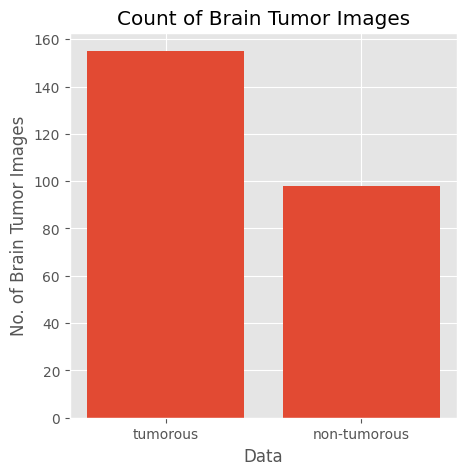

In [6]:
data = {'tumorous': number_files_yes, 'non-tumorous':number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,5))
plt.bar(typex,values)

plt.xlabel("Data")
plt.ylabel("No. of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# **Data Augumentation**
- 155(61% yes) and 98(39% no)
- imbalance data problem 

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19  # Corrected import
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [9]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [8]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [11]:
import time
start_time = time.time()

yes_path = 'brain_tumor_dataset/yes' 
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:1.0335168838500977


In [15]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/" 
    no_path = "augmented_data/no/"
    
    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    
    n = (n_pos + n_neg)
    
    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n
    
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [16]:
data_summary(augmented_data_path)

Number of sample: 2065
1085 Number of positive sample in percentage: 52.54237288135593%
980 Number of negative sample in percentage: 47.45762711864407%


In [17]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1085
980


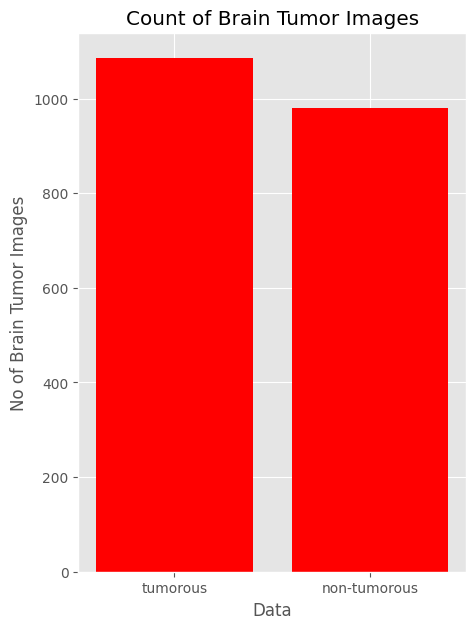

In [18]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Preprocessing
* Convert BGR TO GRAY
* GaussianBlur
* Threshold
* Erode
* Dilate
* Find Contours

In [19]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

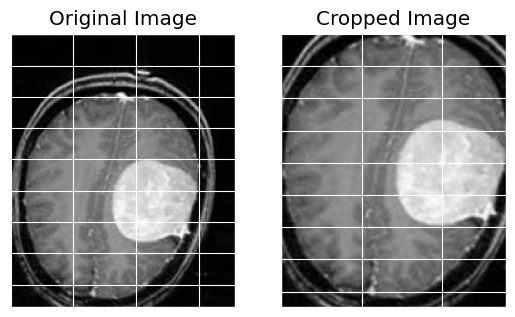

array([[[ 6,  6,  6],
        [ 5,  5,  5],
        [ 4,  4,  4],
        ...,
        [ 7,  7,  7],
        [ 6,  6,  6],
        [ 5,  5,  5]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [12, 12, 12],
        [ 4,  4,  4],
        [ 0,  0,  0]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [14, 14, 14],
        [ 5,  5,  5],
        [ 7,  7,  7]],

       ...,

       [[ 3,  3,  3],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 3,  3,  3],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 6,  6,  6],
        [ 7,  7,  7],
        [ 5,  5,  5],
        ...,
        [ 3,  3,  3],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 3,  3,  3],
        [ 3,  3,  3],
        [ 3,  3,  3],
        ...,
        [ 8,  8,  8],
        [ 7,  7,  7],
        [ 7,  7,  7]]], dtype=uint8)

In [21]:
img = cv2.imread('augmented_data/yes/aug_Y_1_0_634.jpg')
crop_brain_tumor(img, True)

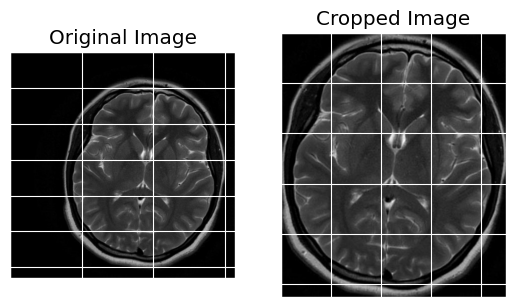

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [23]:
img = cv2.imread('augmented_data/no/aug_N_1_0_1239.jpg')
crop_brain_tumor(img, True)